# Import Library

In [9]:
import steamreviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import re
import logging
import pyodbc
import sqlalchemy


# Extract Data

In [29]:
def extract(app_id = 2076040):
    """
    Function to extract reviews from Steam based on app_id and with most helpful filter then returning a dataframe

    Args:
        app_id (int): Steam game id
    
    Returns:
        df (dataframe): Dataframe of reviews
    """
    request_params = dict()
    # Reference: https://partner.steamgames.com/doc/store/getreviews
    request_params['filter'] = 'recent'
    request_params['language'] = 'english'  # language of the reviews
    request_params['day_range'] = '15'  # maximum range of days

    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id,
                                                                    chosen_request_params=request_params)
    review_data = list(review_dict['reviews'].values())
    df = pd.json_normalize(review_data, )
    return df


#### Scrapping steam reviews

transforming scraped data

In [25]:
def transform(df):
    """
    Function to transform dataframe into a dataframe with only datetime and review column

    Args:
        df (dataframe): Dataframe of reviews

    Returns:
        clean_df (dataframe): Dataframe of reviews with only datetime and review column
    """
    df['time'] = pd.to_datetime(df['timestamp_created'], unit='s')
    df['time'] = df['time'].dt.strftime('%Y-%m-%d')
    df.drop_duplicates(subset=['review'], keep='first', inplace=True)
    clean_df = df[['time', 'review']].reset_index(drop=True).copy()
    clean_df['review'] = clean_df['review'].str.lower()
    return clean_df
    

In [4]:
def transform_2(df_2):
    """
    Function to transform the second data source into a dataframe with aggregating the sum of users per day and 
    datetime column

    Args:
        df_2 (dataframe): Dataframe of Users count per day
    
    Returns:
        clean_df_2 (dataframe): Dataframe of users count per day with datetime column
    """
    clean_df2 = df_2[['DateTime', 'Players']].copy()
    clean_df2['DateTime'] = pd.to_datetime(clean_df2['DateTime'])
    clean_df2['DateTime'] = clean_df2['DateTime'].dt.strftime('%Y-%m-%d')
    clean_df2.rename(columns={'DateTime': 'time'}, inplace=True)
    return clean_df2

In [51]:

request_params = dict()
# request_params['filter'] = 'recent'
request_params['language'] = 'english'
request_params['day_range'] = '30'

app_id = 1084600
review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id,
                                                                    chosen_request_params=request_params)

[appID = 1084600] expected #reviews = 6103


In [55]:
hehe = pd.read_json('./review_1084600.json')
# nemu = pd.json_normalize(list(review_dict['reviews'].values()))
nemu = pd.json_normalize(list(hehe['reviews'].values()))

TypeError: 'numpy.ndarray' object is not callable

In [48]:
nemu = transform(nemu)

In [49]:
nemu

,time,review
0,2023-11-08,if your a fan of my time at portia this is tha...
1,2023-11-08,i have this on nintendo switch also love this ...
2,2023-11-08,juegazooooo
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...
4,2023-11-08,it's nice. hits all the right notes for a fun ...
...,...,...
1023,2023-11-19,玩了两作时光系列，能明显感受到沙石镇在波西亚的基础上又做了不少升级，希望优化再加强下。
1024,2023-11-19,好玩， 快出npc的时装dlc啊。
1025,2023-11-19,1.0单和符文工房比，玩法同样完善，人物塑造也同样立体（以及无厘头），剧情上更有深度，甚至可...
1026,2023-11-19,游戏很好玩，建议手柄设置更加自定义一些。有些新内容可以参考星露谷。


In [30]:
df = extract(1084600)
# df.dtypes
clean_df = transform(df)
clean_df

[appID = 1084600] expected #reviews = 6103


,time,review
0,2023-11-08,if your a fan of my time at portia this is tha...
1,2023-11-08,i have this on nintendo switch also love this ...
2,2023-11-08,juegazooooo
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...
4,2023-11-08,it's nice. hits all the right notes for a fun ...
...,...,...
966,2023-11-15,game good.
967,2023-11-15,this game is silly and story wise you shouldnt...
968,2023-11-15,stardew valley but better
969,2023-11-15,"i largely enjoyed my time at sandrock, with so..."


#### Load users count scraped data

In [6]:
df_2 = pd.read_csv('./data/sandrockv3.csv')
# df_2
clean_df2 = transform_2(df_2)

In [7]:
clean_df2.dtypes

time       object
Players     int64
dtype: object

In [8]:
clean_df2

,time,Players
0,2022-05-26,18683
1,2022-05-27,19612
2,2022-05-28,21778
3,2022-05-29,21162
4,2022-05-30,17540
...,...,...
534,2023-11-11,18231
535,2023-11-12,18838
536,2023-11-13,14098
537,2023-11-14,12878


#### Merging 2 data source

In [9]:
clean_df2

,time,Players
0,2022-05-26,18683
1,2022-05-27,19612
2,2022-05-28,21778
3,2022-05-29,21162
4,2022-05-30,17540
...,...,...
534,2023-11-11,18231
535,2023-11-12,18838
536,2023-11-13,14098
537,2023-11-14,12878


In [10]:
df_combine = pd.merge(clean_df, clean_df2, on='time', how='outer').dropna()
df_combine

,time,review,Players
0,2023-11-08,if your a fan of my time at portia this is tha...,15199
1,2023-11-08,i have this on nintendo switch also love this ...,15199
2,2023-11-08,juegazooooo,15199
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...,15199
4,2023-11-08,it's nice. hits all the right notes for a fun ...,15199
...,...,...,...
796,2023-11-15,chill,8270
797,2023-11-15,speaking from the multi-player mode i am reall...,8270
798,2023-11-15,"the game is very playable, especially like eve...",8270
799,2023-11-15,"i loved playing my time at portia so much, tha...",8270


In [11]:
df_combine['time'] = pd.to_datetime(df_combine['time'], format='%Y-%m-%d')

### Load

In [13]:
connstring = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:rekdat-end2end-l.database.windows.net,1433;Database=RekdatL;Uid=mastamaru;Pwd=3&kMmftBzrtkdYSQ;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'

In [21]:
import pyodbc
import sqlalchemy
sql = """
SELECT table_name, table_schema, table_type
FROM information_schema.tables
ORDER BY table_name ASC;
"""
conn = pyodbc.connect(connstring)
cursor = conn.cursor()
cursor.execute(sql)

In [19]:
# data_sql = cursor.fetchall()
column = [column[0] for column in cursor.description]
print(column)

['table_name', 'table_schema', 'table_type']


In [32]:
conn = pyodbc.connect(connstring)


engine = sqlalchemy.create_engine('mssql+pyodbc://', creator=lambda: conn)
table_name = 'steam_mytimeatsandrock'

df_combine.to_sql(table_name, engine, if_exists='replace', index=False)

conn.close()

In [ ]:
def load(df, table_name):
    """
    Function to load transformed dataframe into Azure SQL Database

    Args :
        df (dataframe): Transformed dataframe of reviews and users count per day
        table_name (str): Table name in Azure SQL Database

    Returns:
        Message of success or failure
    """
    connstring = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:rekdat-end2end-l.database.windows.net,1433;Database=RekdatL;Uid=mastamaru;Pwd=3&kMmftBzrtkdYSQ;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
    conn = pyodbc.connect(connstring)
    engine = sqlalchemy.create_engine('mssql+pyodbc://', creator=lambda: conn)
    df.to_sql(table_name, engine, if_exists='append', index=False)
    conn.close()
    return 'Success'
    

In [31]:
import logging
import time
import pyodbc
import sqlalchemy

def load(df, table_name):
    """
    Function to load transformed dataframe into Azure SQL Database with detailed logging.

    Args:
        df (dataframe): Transformed dataframe of reviews and users count per day
        table_name (str): Table name in Azure SQL Database

    Returns:
        Message of success or failure
    """
    # Inisialisasi logger
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    #Melakukan logging ke file
    handler = logging.FileHandler('etl.log')
    handler.setLevel(logging.INFO)

    # Formatting pesan log
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)

    # Menambahkan handler ke logger
    logger.addHandler(handler)

    try:
        start_time = time.time()  # Waktu awal proses

        # Untuk memberikan Log pesan sebelum mencoba koneksi
        logger.info(f"Memulai proses koneksi ke database '{table_name}'")

        # Proses koneksi ke database dengan connection string
        connstring = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:rekdat-end2end-l.database.windows.net,1433;Database=RekdatL;Uid=mastamaru;Pwd=3&kMmftBzrtkdYSQ;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
        conn = pyodbc.connect(connstring)
        engine = sqlalchemy.create_engine('mssql+pyodbc://', creator=lambda: conn)

        # Logging waktu koneksi
        connect_time = time.time() - start_time
        logger.info(f"Koneksi ke database berhasil dalam {connect_time:.2f} detik")

        # Proses penambahan data
        start_load_time = time.time()  # Waktu awal penambahan data
        df.to_sql(table_name, engine, if_exists='append', index=False) # Menambahkan data ke database, jika tabel sudah ada maka data akan ditambahkan ke tabel tersebut dan data yang sudah ada tidak akan dihapus (hanya menambahkan data baru)

        # Logging setelah penambahan data
        load_time = time.time() - start_load_time
        logger.info(f"Data berhasil ditambahkan ke tabel '{table_name}' dalam {load_time:.2f} detik")

        conn.close() # Menutup koneksi ke database
        total_time = time.time() - start_time # Menghitung total waktu proses
        logger.info(f"Proses load selesai. Total waktu: {total_time:.2f} detik")
        return 'Success'
    except Exception as e:
        logger.error(f"Terjadi error selama proses load: {str(e)}")
        if 'conn' in locals():  # Memastikan bahwa 'conn' ada sebelum mencoba menutupnya
            conn.close()
        return 'Failure'


In [32]:
load(df_combine, 'steam_mytimeatsandrock')

'Success'

In [19]:
import pyodbc
sql = """
SELECT * FROM steam_mytimeatsandrock;
"""
conn = pyodbc.connect(connstring)
cursor = conn.cursor()
cursor.execute(sql)


In [56]:
sql = """
SELECT * FROM steam_mytimeatsandrock;
"""
conn = pyodbc.connect(connstring)
cursor = conn.cursor()
cursor.execute(sql)

fetch_data = cursor.fetchall()
column = [column[0] for column in cursor.description]
conn.close()
df_fetch = pd.DataFrame.from_records(fetch_data, columns=column)
df_fetch

,time,review,Players
0,2023-11-08,"i played portia, a while ago. i've had sandroc...",15199
1,2023-11-08,probably one of the most fun games i've played...,15199
2,2023-11-08,"if you liked my time in portia, then this is m...",15199
3,2023-11-08,a nice follow-up on portia. some nice qol stuf...,15199
4,2023-11-08,"the trailer is very misleading, bought this wi...",15199
...,...,...,...
3279,2023-11-09,i didn't play a lot of my time at portia but i...,15069
3280,2023-11-10,"loved my time at portia, and this game is 10x ...",15092
3281,2023-11-10,very enjoyable,15092
3282,2023-11-10,if you played portia you need to play this. th...,15092


In [58]:
df_fetch.sort_values(by='time', ascending=True)

,time,review,Players
2998,2023-10-09,"just by the content : price ratio alone, this ...",3019
484,2023-10-09,even better then my time at portia!,3019
483,2023-10-09,"just by the content : price ratio alone, this ...",3019
2937,2023-10-09,good game!,3019
482,2023-10-09,good game!,3019
...,...,...,...
1437,2023-11-20,want to reside in a town where you can physica...,10102
1327,2023-11-20,"introduction of each character is good, howeve...",10102
1419,2023-11-20,nice ('v')b !!,10102
1427,2023-11-20,portia but even better,10102


In [21]:
df_fetch.duplicated().sum()

1582

In [20]:
df_fetch[df_fetch['review'].str.contains('perfect mix of animal crossing')]

,time,review,Players
653,2023-11-11,perfect mix of animal crossing and stardew val...,18231
701,2023-11-11,perfect mix of animal crossing and stardew val...,18231
2222,2023-11-11,perfect mix of animal crossing and stardew val...,18231


In [33]:
def load_from_database(table_name):
    """
    Function to load data from Azure SQL Database into dataframe

    Args:
        table_name (str): Table name in Azure SQL Database

    Returns:
        df (dataframe): Dataframe of reviews and users count per day
    """
    connstring = 'Driver={ODBC Driver 18 for SQL Server};Server=tcp:rekdat-end2end-l.database.windows.net,1433;Database=RekdatL;Uid=mastamaru;Pwd=3&kMmftBzrtkdYSQ;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
    conn = pyodbc.connect(connstring)
    sql = f"""
    SELECT * FROM {table_name};
    """
    df = pd.read_sql(sql, conn)
    conn.close()
    return df

In [34]:
df_fetch = load_from_database('steam_mytimeatsandrock')
df_fetch

C:\Users\alghi\AppData\Local\Temp\ipykernel_3152\3403411114.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


,time,review,Players
0,2023-11-08,"i played portia, a while ago. i've had sandroc...",15199
1,2023-11-08,probably one of the most fun games i've played...,15199
2,2023-11-08,"if you liked my time in portia, then this is m...",15199
3,2023-11-08,a nice follow-up on portia. some nice qol stuf...,15199
4,2023-11-08,"the trailer is very misleading, bought this wi...",15199
...,...,...,...
2376,2023-11-09,i didn't play a lot of my time at portia but i...,15069
2377,2023-11-10,"loved my time at portia, and this game is 10x ...",15092
2378,2023-11-10,very enjoyable,15092
2379,2023-11-10,if you played portia you need to play this. th...,15092


In [35]:
df_fetch.to_csv('./data/fetchdata.csv', index=False)

# NLP Sentiment Analysis

In [36]:
import nltk
from nltk.corpus import stopwords

# Mendownload stopwords jika belum pernah didownload sebelumnya
nltk.download('stopwords')

# Mengambil set stopwords yang sudah ada dari NLTK
stop_words = set(stopwords.words('english'))

# Baca file stopwords Anda dan tambahkan ke dalam set
with open('./data/stopwords-en.txt', 'r', encoding='utf-8') as file:
    additional_stopwords = file.read().splitlines()
    stop_words.update(additional_stopwords)

print(stop_words)

{'taken', 'sent', 'hadnt', 'five', 'half', 'gs', 've', 'we', 'available', 'gt', 'respectively', 'her', 'de', "what've", 'thatll', "can't", 'wouldnt', 'whom', 'in', 'ly', 'together', 'thru', 'considering', 'problem', 'oughtnt', 'sn', "we'll", 'rooms', 'thereve', 'got', 'provides', 'think', 'lu', 'someday', 'obviously', "why'd", 'herself', 'biol', 'ni', 'always', 'could', 'its', 'cant', 'ie', 'anywhere', 'si', 'generally', 'words', "ain't", 'dare', 'years', 'already', 'backwards', 'help', 'kind', 'effect', 'serious', 'was', 'apart', 'et-al', 'getting', 'similarly', 'second', 'sz', 'hasnt', 'thought', 'lt', 'ableabout', 'hasn', 'appear', 'himse”', 'states', "it's", 'gotten', 'g', 'brief', 'eighty', 'toward', 'havent', 'significantly', "hadn't", 'obtain', 'cannot', 'cx', 'highest', 'eg', 'amoungst', 'neednt', 'throug', 'one', 'whoever', 'shan', 'tf', 'often', 'all', 'ltd', 'though', 'ending', 'hardly', 'heres', "we've", 'ke', 'ends', 'then', 'sec', 'our', 'out', 'another', 'fifteen', 'ki',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def preprocess_tweet(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  # text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('^(\@\w+ ?)+',' ',text)
  text = re.sub(r'\@\w+',' ',text) # Remove every username
  text = re.sub(r'\#\w+',' ',text) # Remove every hashtag
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('/', ' ', text)
  # text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text

def remove_nonalphanumeric(text):
  text = re.sub('&amp;', ' ', text)  # Mengganti &amp; dengan spasi
  text = re.sub('[^0-9a-zA-Z]+', ' ', text)  # Mengganti semua karakter non-alphanumeric dengan spasi
  text = re.sub('  +', ' ', text)  # Menggabungkan spasi yang berlebih
  return text.strip()  # Menghapus spasi di awal dan akhir string


def remove_stopword(text):
  text = re.sub('[.,!?]','',text)
  text = ' '.join(['' if word in stop_words else word for word in text.split(' ')]) #Mengganti stopword dengan ''
  text = re.sub('  +', ' ', text)
  text = text.title()
  text = text.strip() #Menghapus spasi atau newline di awal dan akhir kalimat yang tidak diperlukan
  return text

In [38]:
def preprocess(text):
  text = preprocess_tweet(text)
  text = remove_nonalphanumeric(text)
  return text


In [39]:
df_combine['review_clean'] = df_combine['review'].apply(preprocess)
df_combine['review_clean'] = df_combine['review_clean'].apply(remove_stopword) 

In [40]:
df_combine.loc[:, ['review', 'review_clean']]

,review,review_clean
0,if your a fan of my time at portia this is tha...,Fan Time Portia
1,i have this on nintendo switch also love this ...,Nintendo Switch Love Time Portia
2,juegazooooo,Juegazooooo
3,very much addicting/chaotic gotta-go and gotta...,Addicting Chaotic Gotta Gotta Game Fun Game
4,it's nice. hits all the right notes for a fun ...,Nice Hits Notes Fun Engaging Farming Crafting ...
...,...,...
796,chill,Chill
797,speaking from the multi-player mode i am reall...,Speaking Multi Player Mode Enjoying Game Bit S...
798,"the game is very playable, especially like eve...",Game Playable Town Dubbing Complete
799,"i loved playing my time at portia so much, tha...",Loved Playing Time Portia Hesitant Starting Sa...


In [41]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english", tokenizer="siebert/sentiment-roberta-large-english", truncation=True)

In [42]:
# Menerapkan model dalam batch dan menyimpan hasilnya dalam kolom 'sentiment_label'
df_combine['sentiment_label'] = [result['label'] for result in nlp(df_combine['review'].tolist())]


In [43]:
df_combine['positive'] = df_combine['sentiment_label'].apply(lambda x: 1 if x == 'POSITIVE' else 0)
df_combine['negative'] = df_combine['sentiment_label'].apply(lambda x: 1 if x == 'NEGATIVE' else 0)

In [44]:
df_combine['sentiment_ratio'] = df_combine.groupby('time')['positive'].transform('sum') / (df_combine.groupby('time')['negative'].transform('sum') + df_combine.groupby('time')['positive'].transform('sum'))

In [45]:
df_combine

,time,review,Players,review_clean,sentiment_label,positive,negative,sentiment_ratio
0,2023-11-08,if your a fan of my time at portia this is tha...,15199,Fan Time Portia,POSITIVE,1,0,0.906977
1,2023-11-08,i have this on nintendo switch also love this ...,15199,Nintendo Switch Love Time Portia,POSITIVE,1,0,0.906977
2,2023-11-08,juegazooooo,15199,Juegazooooo,POSITIVE,1,0,0.906977
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...,15199,Addicting Chaotic Gotta Gotta Game Fun Game,POSITIVE,1,0,0.906977
4,2023-11-08,it's nice. hits all the right notes for a fun ...,15199,Nice Hits Notes Fun Engaging Farming Crafting ...,POSITIVE,1,0,0.906977
...,...,...,...,...,...,...,...,...
796,2023-11-15,chill,8270,Chill,POSITIVE,1,0,1.000000
797,2023-11-15,speaking from the multi-player mode i am reall...,8270,Speaking Multi Player Mode Enjoying Game Bit S...,POSITIVE,1,0,1.000000
798,2023-11-15,"the game is very playable, especially like eve...",8270,Game Playable Town Dubbing Complete,POSITIVE,1,0,1.000000
799,2023-11-15,"i loved playing my time at portia so much, tha...",8270,Loved Playing Time Portia Hesitant Starting Sa...,POSITIVE,1,0,1.000000


In [46]:
df_combine['positive_count'] = df_combine.groupby('time')['positive'].transform('sum')
df_combine['negative_count'] = df_combine.groupby('time')['negative'].transform('sum')

In [47]:
df_combine['sentiment_ratio'] = df_combine.groupby('time')['positive'].transform('sum') / (df_combine.groupby('time')['negative'].transform('sum') + df_combine.groupby('time')['positive'].transform('sum'))

In [48]:
df_combine

,time,review,Players,review_clean,sentiment_label,positive,negative,sentiment_ratio,positive_count,negative_count
0,2023-11-08,if your a fan of my time at portia this is tha...,15199,Fan Time Portia,POSITIVE,1,0,0.906977,39,4
1,2023-11-08,i have this on nintendo switch also love this ...,15199,Nintendo Switch Love Time Portia,POSITIVE,1,0,0.906977,39,4
2,2023-11-08,juegazooooo,15199,Juegazooooo,POSITIVE,1,0,0.906977,39,4
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...,15199,Addicting Chaotic Gotta Gotta Game Fun Game,POSITIVE,1,0,0.906977,39,4
4,2023-11-08,it's nice. hits all the right notes for a fun ...,15199,Nice Hits Notes Fun Engaging Farming Crafting ...,POSITIVE,1,0,0.906977,39,4
...,...,...,...,...,...,...,...,...,...,...
796,2023-11-15,chill,8270,Chill,POSITIVE,1,0,1.000000,8,0
797,2023-11-15,speaking from the multi-player mode i am reall...,8270,Speaking Multi Player Mode Enjoying Game Bit S...,POSITIVE,1,0,1.000000,8,0
798,2023-11-15,"the game is very playable, especially like eve...",8270,Game Playable Town Dubbing Complete,POSITIVE,1,0,1.000000,8,0
799,2023-11-15,"i loved playing my time at portia so much, tha...",8270,Loved Playing Time Portia Hesitant Starting Sa...,POSITIVE,1,0,1.000000,8,0


C:\Users\alghi\AppData\Local\Temp\ipykernel_31476\2630146847.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_combine, x='sentiment_ratio', y='Players', ci=None)


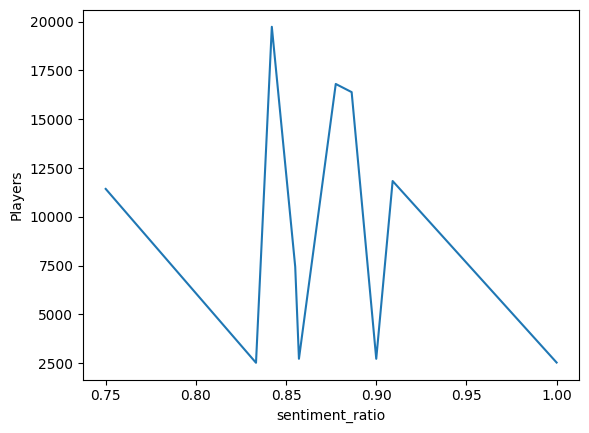

In [31]:
sns.lineplot(data=df_combine, x='sentiment_ratio', y='Players', ci=None)
plt.show()

C:\Users\alghi\AppData\Local\Temp\ipykernel_31476\2481753522.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_combine, x='time', y='Players', ci=None)


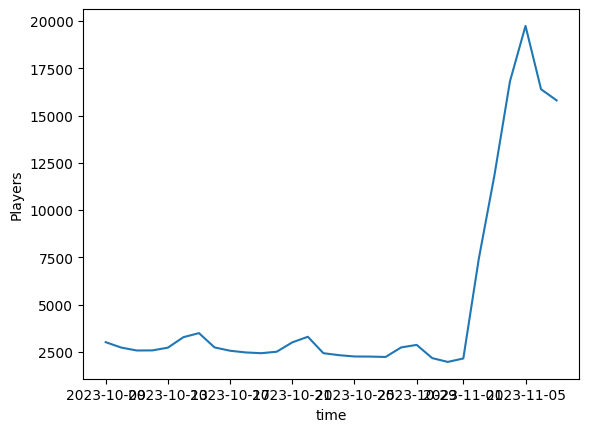

In [34]:
sns.lineplot(data=df_combine, x='time', y='Players', ci=None)
plt.show()

In [52]:
daily_sentiment = df_combine.set_index('time')[['sentiment_ratio', 'positive_count', 'negative_count', 'Players']].resample('D').mean()

comparing sentiment ratio with players count

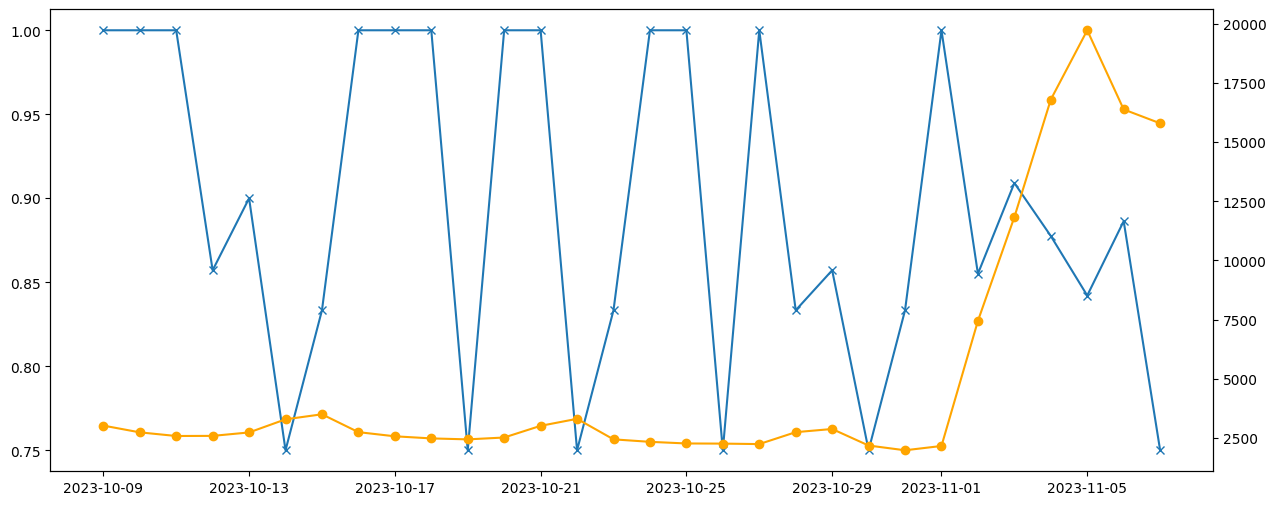

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_sentiment['sentiment_ratio'].index, daily_sentiment['sentiment_ratio'], marker='x')
#combine the y axis
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(daily_sentiment.index, daily_sentiment['Players'], color='orange', marker='o')
plt.xticks(rotation=45)
plt.show()

corellation plot between players and sentiment ratio

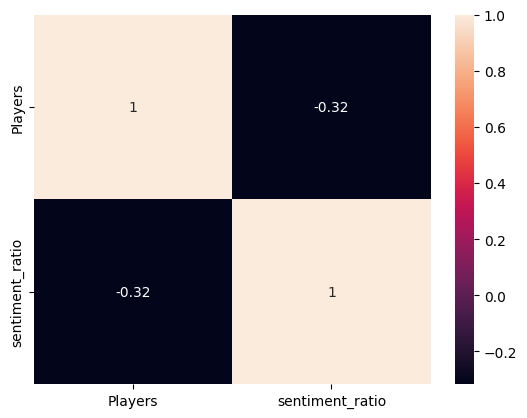

In [61]:
sns.heatmap(df_combine[['Players', 'sentiment_ratio']].corr(), annot=True)
plt.show()

wordcloud of positive and negative reviews, to get insight of what players like and dislike

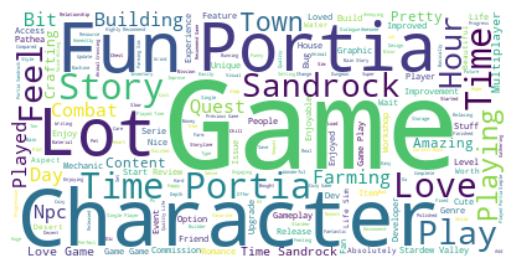

In [49]:
#create wordcloud from positive reviews
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

df_positive = df_combine[df_combine['sentiment_label'] == 'POSITIVE']

text = " ".join(review for review in df_positive.review_clean)

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

summarize with lda

In [55]:
df_positive

,time,review,Players,review_clean,sentiment_label,positive,negative,sentiment_ratio,positive_count,negative_count
0,2023-11-08,if your a fan of my time at portia this is tha...,15199,Fan Time Portia,POSITIVE,1,0,0.906977,39,4
1,2023-11-08,i have this on nintendo switch also love this ...,15199,Nintendo Switch Love Time Portia,POSITIVE,1,0,0.906977,39,4
2,2023-11-08,juegazooooo,15199,Juegazooooo,POSITIVE,1,0,0.906977,39,4
3,2023-11-08,very much addicting/chaotic gotta-go and gotta...,15199,Addicting Chaotic Gotta Gotta Game Fun Game,POSITIVE,1,0,0.906977,39,4
4,2023-11-08,it's nice. hits all the right notes for a fun ...,15199,Nice Hits Notes Fun Engaging Farming Crafting ...,POSITIVE,1,0,0.906977,39,4
...,...,...,...,...,...,...,...,...,...,...
796,2023-11-15,chill,8270,Chill,POSITIVE,1,0,1.000000,8,0
797,2023-11-15,speaking from the multi-player mode i am reall...,8270,Speaking Multi Player Mode Enjoying Game Bit S...,POSITIVE,1,0,1.000000,8,0
798,2023-11-15,"the game is very playable, especially like eve...",8270,Game Playable Town Dubbing Complete,POSITIVE,1,0,1.000000,8,0
799,2023-11-15,"i loved playing my time at portia so much, tha...",8270,Loved Playing Time Portia Hesitant Starting Sa...,POSITIVE,1,0,1.000000,8,0


In [56]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import re

# Vectorize teks
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(df_positive['review_clean'])

# Latent Dirichlet Allocation
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(data_vectorized)

# Fungsi untuk menampilkan topik
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Menampilkan topik
display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
game time portia love fun sandrock amazing playing play story
Topic 1:
game time portia sandrock characters story games lot fun play
Topic 2:
game cute pretty nice fun improvement character life release simulator
Topic 3:
game character story portia deck sandrock time worth npcs steam
Topic 4:
game time multiplayer fun games play combat lot player portia


wordcloud negatif label

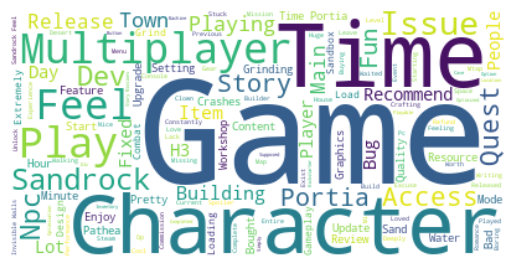

In [58]:
df_negative = df_combine[df_combine['sentiment_label'] == 'NEGATIVE']

text = " ".join(review for review in df_negative.review_clean)

wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [59]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import re

# Vectorize teks
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(df_negative['review_clean'])

# Latent Dirichlet Allocation
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(data_vectorized)

# Fungsi untuk menampilkan topik
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Menampilkan topik
display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
game time portia multiplayer devs sandrock walls invisible day play
Topic 1:
time shit optimized portia bad optimization incredibly chance kickstarter enjoyed
Topic 2:
game time character sandrock h3 feels feel portia npcs characters
Topic 3:
game sandrock town grinding people feels building water console multiplayer
Topic 4:
game multiplayer play story issues time loading access fixed release
